### On télécharge les entités depuis Anthologia

In [3]:
import requests
entities = requests.get('https://anthologia.ecrituresnumeriques.ca/api/v1/entities/').json()

### On va enlever la ponctuation

In [6]:
import string
def clean(text):
    return "".join([
        c for c in text
        if c not in string.punctuation
    ]).lower()

### Nettoyage avec la fonction clean + récupération d'un tuple (titre, texte)

In [7]:
texts = list()
for entity in entities:
    for version in entity['versions']:
        if version['id_language'] == 3: 
            if 'Iliad' not in entity['title']: # l'iliade fait bcp de bruit!
                text = clean(version['text_translated'])
                title = entity['title']
                texts.append((title, text))

### On nettoie les textes (token + lem)

On enlève les stopwords et on  ne garde que les tokens de plus de 3 lettres

In [63]:
import nltk
import gensim
from nltk.stem import SnowballStemmer, WordNetLemmatizer

# Au cas où je sais jamais trop
nltk.download('wordnet')

stemmer = SnowballStemmer("english")

def lem_stem(text):
    lems = WordNetLemmatizer().lemmatize(text, pos='v')
    return stemmer.stem(lems)

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lem_stem(token))
    return result

# Nettoyage (le texte est le deuxième élément du tuple)
processed = [preprocess(text[1]) for text in texts]


[nltk_data] Downloading package wordnet to /home/timg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### On se fait un dictionnaire de mots

On garde 10.000 tokens, et on ne garde que ceux qui apparaissent dans plus de 5 documents et ne représentent pas plus de 50% du corpus total (https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html)

In [22]:
dictionary = gensim.corpora.Dictionary(processed)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=10000)
corpus = [dictionary.doc2bow(doc) for doc in processed]

### On fait le LDA (10 topics)

In [23]:
lda_model = gensim.models.LdaMulticore(corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

### Voilà les topics

In [28]:
for topic_id, formula in lda_model.print_topics():
    print(topic_id, formula)

0 0.013*"hade" + 0.013*"love" + 0.012*"tomb" + 0.010*"muse" + 0.009*"ship" + 0.009*"tell" + 0.008*"great" + 0.008*"earth" + 0.008*"land" + 0.007*"shall"
1 0.031*"thou" + 0.018*"death" + 0.014*"thee" + 0.011*"tomb" + 0.010*"earth" + 0.010*"father" + 0.010*"come" + 0.007*"eye" + 0.007*"love" + 0.007*"hand"
2 0.017*"grace" + 0.013*"wisdom" + 0.012*"muse" + 0.010*"love" + 0.009*"sweet" + 0.009*"leav" + 0.009*"hold" + 0.009*"hous" + 0.008*"countri" + 0.007*"word"
3 0.015*"shall" + 0.014*"thou" + 0.011*"tomb" + 0.010*"love" + 0.009*"know" + 0.009*"thee" + 0.009*"littl" + 0.008*"christ" + 0.008*"light" + 0.008*"earth"
4 0.028*"thou" + 0.018*"tomb" + 0.015*"life" + 0.012*"didst" + 0.012*"know" + 0.011*"love" + 0.009*"thee" + 0.009*"father" + 0.009*"leav" + 0.008*"sweet"
5 0.019*"come" + 0.013*"bring" + 0.009*"love" + 0.009*"tomb" + 0.009*"land" + 0.008*"thou" + 0.008*"dead" + 0.008*"say" + 0.007*"life" + 0.007*"shall"
6 0.014*"love" + 0.013*"death" + 0.012*"like" + 0.011*"life" + 0.011*"look" 

### Exemple: le texte d'indice 10

In [30]:
lda_model[corpus[10]]

[(0, 0.011116129),
 (1, 0.01111522),
 (2, 0.01111491),
 (3, 0.32559255),
 (4, 0.011115691),
 (5, 0.011115616),
 (6, 0.011115945),
 (7, 0.01111543),
 (8, 0.5854838),
 (9, 0.01111472)]

In [40]:
print("###", texts[10][0])

for topic_id, frequency in lda_model[corpus[10]]:
    print("Topic:", topic_id, "frequency", frequency)

### Greek Anthology 5.11
Topic: 0 frequency 0.011116623
Topic: 1 frequency 0.011115267
Topic: 2 frequency 0.01111529
Topic: 3 frequency 0.011116812
Topic: 4 frequency 0.011116303
Topic: 5 frequency 0.011115572
Topic: 6 frequency 0.011115847
Topic: 7 frequency 0.011115566
Topic: 8 frequency 0.8999579
Topic: 9 frequency 0.011114866


### On peut regarder à quoi correspond chaque topic (ici on va regarder le 8)

In [41]:
for word_id, frequency in lda_model.get_topic_terms(8):
    print("Word ID", word_id, "frequency", frequency)

Word ID 102 frequency 0.028270947
Word ID 78 frequency 0.021564493
Word ID 508 frequency 0.016795695
Word ID 268 frequency 0.011849673
Word ID 5 frequency 0.0116985785
Word ID 420 frequency 0.011032931
Word ID 456 frequency 0.009328718
Word ID 137 frequency 0.008845457
Word ID 450 frequency 0.008167612
Word ID 171 frequency 0.008004178


In [42]:
for word_id, frequency in lda_model.get_topic_terms(8):
    print("Word:", dictionary[word_id], "frequency", frequency)

Word: thee frequency 0.028270947
Word: thou frequency 0.021564493
Word: mother frequency 0.016795695
Word: dead frequency 0.011849673
Word: love frequency 0.0116985785
Word: tomb frequency 0.011032931
Word: hade frequency 0.009328718
Word: mourn frequency 0.008845457
Word: father frequency 0.008167612
Word: tear frequency 0.008004178


In [46]:
# Relativement équivalent: texte indice 10, topic indice 8
lda_model.print_topics(10)[8]

(8,
 '0.028*"thee" + 0.022*"thou" + 0.017*"mother" + 0.012*"dead" + 0.012*"love" + 0.011*"tomb" + 0.009*"hade" + 0.009*"mourn" + 0.008*"father" + 0.008*"tear"')

### Faisons un joli dessin

#### On commence par l'axe des X: la liste des topics

Ici je joins tous les mots du topic avec des , (je perds la fréquence mais c'est ordonné en décroissant).
J'obtiens une liste, dont chaque élément contient une liste de mots séparés par des , (mais c'est une seule chaîne).

In [49]:
xlabels = [
        ",".join(
            [
                dictionary[word_id]
                for word_id, freq in lda_model.get_topic_terms(topic_id)
            ]
        )
        for topic_id in range(lda_model.num_topics)
    ]
xlabels

['hade,love,tomb,muse,ship,tell,great,earth,land,shall',
 'thou,death,thee,tomb,earth,father,come,eye,love,hand',
 'grace,wisdom,muse,love,sweet,leav,hold,hous,countri,word',
 'shall,thou,tomb,love,know,thee,littl,christ,light,earth',
 'thou,tomb,life,didst,know,love,thee,father,leav,sweet',
 'come,bring,love,tomb,land,thou,dead,say,life,shall',
 'love,death,like,life,look,hade,tomb,leav,say,shall',
 'tomb,love,die,leav,longer,earth,thou,come,soul,stranger',
 'thee,thou,mother,dead,love,tomb,hade,mourn,father,tear',
 'thou,tomb,love,thee,dead,life,earth,live,tell,drink']

J'ai la liste des mots pour chaque topic.

#### Axe des Y: les textes (on  prend les titres)

In [64]:
ylabels = [t[0] for t in texts]
ylabels[:5] # Juste pour voir

['Greek Anthology 5.6',
 'Greek Anthology 4.1',
 'Greek Anthology 5.3',
 'Greek Anthology 5.4',
 'Greek Anthology 5.5']

#### Très bien. On va construire un dataframe avec pandas

Ce sera une matrice 2D - topics en colonnes, et textes en lignes. Chaque "case" contient la fréquence de ce topic dans le texte correspondant. On commence par faire une matrice remplie de zéros.

In [57]:
import numpy as np
from pandas import DataFrame as DF

heatmap = DF(
        np.zeros([len(processed), lda_model.num_topics]),
        columns=xlabels,
        index=ylabels,
    )

#### Maintenant on remplit la matrice avec les informations du modèle

In [59]:
for idx in range(len(texts)):
    # Là on prend les scores pour ce texte
    scores = lda_model[corpus[idx]]
    # On obtient une liste de topics avec les scores
    for topic_id, score in scores:
        # On remplit la matrice aux bons endroits
        heatmap.iloc[idx, topic_id] = score

### Ne reste plus qu'à faire une clustermap avec Seaborn

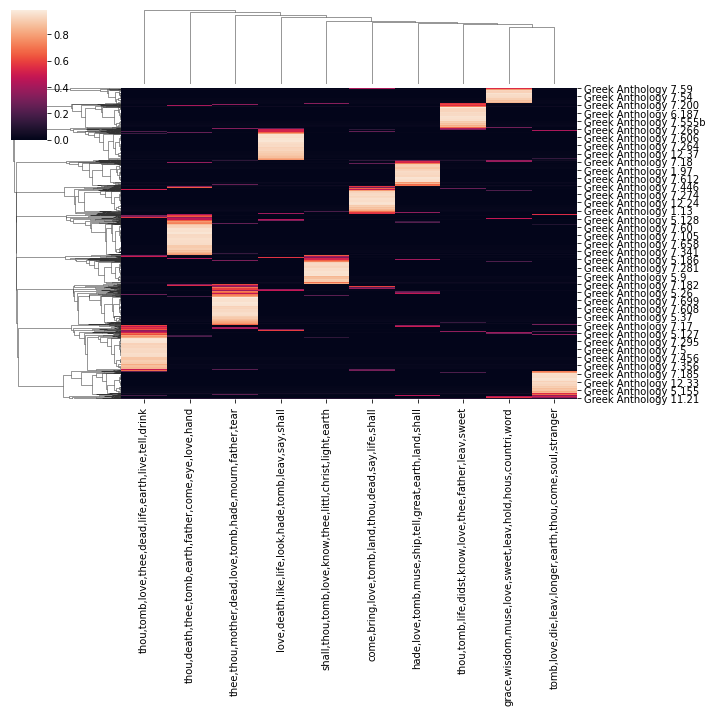

In [62]:
import seaborn as sns

sns.clustermap(heatmap)